In [5]:
! pip install -U langchain openai langchain-chroma langchain-experimental 
! pip install --user pillow pydantic lxml pillow matplotlib chromadb tiktoken
! pip install gradio
! pip install azure-ai-formrecognizer   

  Using cached build-1.2.2.post1-py3-none-any.whl.metadata (6.5 kB)
  Using cached chroma_hnswlib-0.7.6-cp312-cp312-win_amd64.whl


ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: 'C:\\users\\bnaik6\\appdata\\local\\pip\\cache\\wheels\\28\\29\\0e\\934c768c2e673547ec6e947e821346f4ed691a089fe046743f\\chroma_hnswlib-0.7.6-cp312-cp312-win_amd64.whl'
Consider using the `--user` option or check the permissions.



## Data Loading

##### Extract tables, text from PDFs using Azure Form Recognizer
##### Extract images from PDFs using pyumpdf
```

In [125]:
import os  
import fitz  # PyMuPDF  
from azure.ai.formrecognizer import FormRecognizerClient  
from azure.core.credentials import AzureKeyCredential  
  
# Replace these with your actual Form Recognizer endpoint and API key  
endpoint = ""  
api_key = "" 
  
form_recognizer_client = FormRecognizerClient(endpoint, AzureKeyCredential(api_key))  
  
def analyze_document(file_path):  
    with open(file_path, "rb") as file:  
        poller = form_recognizer_client.begin_recognize_content(file)  
        result = poller.result()  
    return result  
  
def extract_text_tables(result):  
    extracted_data = {  
        "pages": []  
    }  
  
    for page_number, page in enumerate(result):  
        page_data = {  
            "page_number": page_number + 1,  
            "text": "",  
            "tables": []  
        }  
  
        # Extract text  
        if hasattr(page, 'lines') and page.lines is not None:  
            for line in page.lines:  
                page_data["text"] += line.text + "\n"  
  
        # Extract tables  
        if hasattr(page, 'tables') and page.tables is not None:  
            for table in page.tables:  
                extracted_table = []  
                for cell in table.cells:  
                    extracted_table.append({  
                        "text": cell.text,  
                        "row_index": cell.row_index,  
                        "column_index": cell.column_index  
                    })  
                page_data["tables"].append(extracted_table)  
  
        extracted_data["pages"].append(page_data)  
  
    return extracted_data 
  
def extract_images_from_pdf(file_path):  
    images = []  
    document = fitz.open(file_path)  
  
    for page_number in range(len(document)):  
        page = document.load_page(page_number)  
        for img_index, img in enumerate(page.get_images(full=True)):  
            xref = img[0]  
            base_image = document.extract_image(xref)  
            image_bytes = base_image["image"]  
            image_ext = base_image["ext"]  
            image_info = {  
                "image_bytes": image_bytes,  
                "image_ext": image_ext,  
                "page_number": page_number + 1,  
                "img_index": img_index + 1  
            }  
            images.append(image_info)  
  
    return images  
  

def save_extracted_data(output_folder, file_name, extracted_data, images):  
    base_name, _ = os.path.splitext(file_name)  
    file_output_folder = os.path.join(output_folder, base_name)  
  
    text_folder = os.path.join(file_output_folder, 'text')  
    tables_folder = os.path.join(file_output_folder, 'tables')  
    images_folder = os.path.join(file_output_folder, 'images')  
  
    os.makedirs(text_folder, exist_ok=True)  
    os.makedirs(tables_folder, exist_ok=True)  
    os.makedirs(images_folder, exist_ok=True)  
  
    # Save text and tables page-wise  
    for page in extracted_data["pages"]:  
        page_number = page["page_number"]  
  
        # Save text  
        text_file_path = os.path.join(text_folder, f"page_{page_number}_text.txt")  
        with open(text_file_path, "w", encoding="utf-8") as text_file:  
            text_file.write(page["text"])  
  
        # Save tables  
        for i, table in enumerate(page["tables"]):  
            table_file_path = os.path.join(tables_folder, f"page_{page_number}_table_{i}.txt")  
            with open(table_file_path, "w", encoding="utf-8") as table_file:  
                for cell in table:  
                    table_file.write(f"Row: {cell['row_index']}, Column: {cell['column_index']}, Text: {cell['text']}\n")  
    # Save images  
    for i, image in enumerate(images):  
        image_file_path = os.path.join(images_folder, f"page_{image['page_number']}_img_{image['img_index']}.{image['image_ext']}")  
        with open(image_file_path, "wb") as image_file:  
            image_file.write(image["image_bytes"])  
        # print(f"Saved image {i} on page {image['page_number']}")

def process_documents(input_folder, output_folder):  
    for file_name in os.listdir(input_folder):  
        if file_name.endswith(".pdf"):  
            document_path = os.path.join(input_folder, file_name)  
            print(f"File Name {file_name}")
            result = analyze_document(document_path)  
            extracted_data = extract_text_tables(result)  
            images = extract_images_from_pdf(document_path)  
            save_extracted_data(output_folder, file_name, extracted_data, images)  


In [127]:
input_folder = r"C:\Users\BNAIK6\Documents\test\Franklin\input"  # Change this to the path of your input folder  
output_folder = r"C:\Users\BNAIK6\Documents\test\Franklin\output"  # Change this to your desired output folder  

process_documents(input_folder, output_folder)

Saved image 0 on page 1
Saved image 1 on page 1
Saved image 2 on page 1
Saved image 3 on page 2
Saved image 4 on page 2
Saved image 5 on page 2
Saved image 6 on page 2
Saved image 7 on page 3
Saved image 8 on page 3
Saved image 9 on page 3
Saved image 10 on page 4
Saved image 11 on page 4
Saved image 12 on page 4
Saved image 13 on page 4
Saved image 14 on page 4
Saved image 15 on page 4
Saved image 16 on page 5
Saved image 17 on page 5
Saved image 18 on page 5
Saved image 19 on page 5
Saved image 20 on page 5
Saved image 21 on page 6
Saved image 22 on page 6
Saved image 23 on page 6
Saved image 24 on page 6
Saved image 25 on page 6
Saved image 26 on page 6
Saved image 27 on page 7
Saved image 28 on page 7
Saved image 29 on page 7
Saved image 30 on page 7
Saved image 31 on page 7
Saved image 32 on page 7
Saved image 33 on page 7
Saved image 34 on page 7
Saved image 35 on page 8
Saved image 36 on page 8
Saved image 37 on page 8
Saved image 38 on page 8
Saved image 39 on page 8
Saved imag

## Multi-vector retriever

Used multi-vector retriver to index image (and / or text, table) summaries, but retrieve raw images (along with raw texts or tables).

### Text and Table summaries

We will use GPT-4o to produce table and text summaries.

Summaries are used to retrieve raw tables and raw chunks of text.

In [189]:
import os  

file_contents = []  
def read_txt_files(directory):  


    # Iterate over all files in the directory  
    for filename in os.listdir(directory):  
        # Check if the file is a .txt file  
        if filename.endswith(".txt"):  
            # Construct the full file path  
            filepath = os.path.join(directory, filename)  
            # Open and read the file  
            with open(filepath, 'r',encoding="utf-8") as file:  
                # Append the contents of the file to the list  
                file_contents.append(file.read())  
  
    return file_contents  


In [191]:
os.listdir(input_folder)

['168-176-Ocean-Ave-Jersey-City-NJ-OM-3.pdf',
 '210111_300_E-Main_Street_OFFERING_MEMORANDUM.pdf',
 '607-647-Gilbert-OM-V2.pdf',
 '64135318fb8868000730cacf_jordan_lake_ave_820_lake_odessa_advantage_cre_om.pdf',
 'b0d07518-2a0c-4e0b-ad0a-83421417a6eb.pdf',
 'document.pdf',
 'Greens-Retail-Warehouse-Center-OM-MM.pdf',
 'Guterman-Real-Estate-Partners-47-Investment-Summary-and-Offering-Memorandum.pdf',
 'InvestMemo-609-615-E-26thSt.pdf',
 'Lund-PointeApts_OfferingMemorandum.pdf',
 'Offering-Memorandum.pdf',
 'The-Post-Offering-Memorandum-8-2023.pdf']

In [193]:
for file_name in os.listdir(input_folder):
    file_name=file_name.split(".pdf")[0]
    txt_file_path=os.path.join(output_folder,file_name,"text")
    tables_file_path=os.path.join(output_folder,file_name,"tables")
    img_file_path=os.path.join(output_folder,file_name,"images")
    texts, tables =  read_txt_files(txt_file_path),read_txt_files(tables_file_path)    

In [12]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain.chat_models import AzureChatOpenAI


# Generate summaries of text elements
def generate_text_summaries(texts, tables, summarize_texts=False):
    """
    Summarize text elements
    texts: List of str
    tables: List of str
    summarize_texts: Bool to summarize texts
    """

    # Prompt
    prompt_text = """You are an assistant tasked with summarizing tables and text for retrieval. \
    These summaries will be embedded and used to retrieve the raw text or table elements. \
    Give a concise summary of the table or text that is well optimized for retrieval. Table or text: {element} """
    prompt = ChatPromptTemplate.from_template(prompt_text)

    # Text summary chain
    model = AzureChatOpenAI(
    openai_api_version="2024-02-15-preview",
    api_key = "e20c354227f54dd2b3c2d94e655abbfb",
    azure_endpoint="https://mo3t74sryevsuy6openai.openai.azure.com/openai/deployments/GPT-4o/chat/completions?api-version=2024-06-01",
    temperature=0,
    )
    summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

    # Initialize empty summaries
    text_summaries = []
    table_summaries = []

    # Apply to text if texts are provided and summarization is requested
    if texts and summarize_texts:
        text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})
    elif texts:
        text_summaries = texts

    # Apply to tables if tables are provided
    if tables:
        table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

    return text_summaries, table_summaries


# # Get text, table summaries
text_summaries, table_summaries = generate_text_summaries(
    texts, tables, summarize_texts=False
)

### Image summaries 

Used GPT-4o  to produce the image summaries.

We pass base64 encoded images as input

In [217]:
import base64
import os

from langchain_core.messages import HumanMessage


def encode_image(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def image_summarize(img_base64, prompt):
    """Make image summary"""
    chat = AzureChatOpenAI(
    openai_api_version="",
    api_key = "",
    azure_endpoint="https://mo3t74sryevsuy6openai.openai.azure.com/openai/deployments/GPT-4o/chat/completions?api-version=2024-06-01",
    temperature=0,
    max_tokens=1024
    )

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    return msg.content


def generate_img_summaries(path):
    """
    Generate summaries and base64 encoded strings for images
    path: Path to list of .jpg files extracted by Unstructured
    """



    # Prompt
    prompt = """You are an assistant tasked with summarizing images for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a concise summary of the image that is well optimized for retrieval."""

    # Apply to images
    for img_file in sorted(os.listdir(path)):
        if img_file.endswith(".jpeg"):
            img_path = os.path.join(path, img_file)
            base64_image = encode_image(img_path)
            img_base64_list.append(base64_image)
            image_summaries.append(image_summarize(base64_image, prompt))

    return img_base64_list, image_summaries



# Store base64 encoded images
img_base64_list = []

# Store image summaries
image_summaries = []


# Image summaries
for file_name in os.listdir(input_folder):
    file_name=file_name.split(".pdf")[0]
    img_file_path=os.path.join(output_folder,file_name,"images")
    print(f"file_name {img_file_path}")
    img_base64_list, image_summaries = generate_img_summaries(img_file_path)

file_name C:\Users\BNAIK6\Documents\test\Franklin\output\168-176-Ocean-Ave-Jersey-City-NJ-OM-3\images
file_name C:\Users\BNAIK6\Documents\test\Franklin\output\210111_300_E-Main_Street_OFFERING_MEMORANDUM\images
file_name C:\Users\BNAIK6\Documents\test\Franklin\output\607-647-Gilbert-OM-V2\images
file_name C:\Users\BNAIK6\Documents\test\Franklin\output\64135318fb8868000730cacf_jordan_lake_ave_820_lake_odessa_advantage_cre_om\images
file_name C:\Users\BNAIK6\Documents\test\Franklin\output\b0d07518-2a0c-4e0b-ad0a-83421417a6eb\images
file_name C:\Users\BNAIK6\Documents\test\Franklin\output\document\images
file_name C:\Users\BNAIK6\Documents\test\Franklin\output\Greens-Retail-Warehouse-Center-OM-MM\images
file_name C:\Users\BNAIK6\Documents\test\Franklin\output\Guterman-Real-Estate-Partners-47-Investment-Summary-and-Offering-Memorandum\images
file_name C:\Users\BNAIK6\Documents\test\Franklin\output\InvestMemo-609-615-E-26thSt\images
file_name C:\Users\BNAIK6\Documents\test\Franklin\output\L

### Add to vectorstore

Add raw docs and doc summaries to multi-vector retriver: 

* Store the raw texts, tables, and images in the docstore.
* Store the texts, table summaries, and image summaries in the vectorstore for efficient semantic retrieval.

In [1]:
import uuid,os

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain.vectorstores import Chroma
from langchain_core.documents import Document
from langchain_openai import AzureOpenAIEmbeddings


embeddings = AzureOpenAIEmbeddings(
    api_key = "",
    azure_endpoint=""
)

def create_multi_vector_retriever(
    vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images
):
    """
    Create retriever that indexes summaries, but returns raw images or texts
    """

    # Initialize the storage layer
    store = InMemoryStore()
    id_key = "doc_id"

    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )

    # Helper function to add documents to the vectorstore and docstore
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

    # Add texts, tables, and images
    # Check that text_summaries is not empty before adding
    if text_summaries:
        add_documents(retriever, text_summaries, texts)
    # Check that table_summaries is not empty before adding
    if table_summaries:
        add_documents(retriever, table_summaries, tables)
    # Check that image_summaries is not empty before adding
    if image_summaries:
        add_documents(retriever, image_summaries, images)

    return retriever


def save_retriever(retriever, file_path):  
    """Save the retriever to a file"""  
    with open(file_path, "wb") as file:  
        pickle.dump(retriever, file)  
  
def load_retriever(file_path, vectorstore):  
    """Load the retriever from a file"""  
    with open(file_path, "rb") as file:  
        retriever = pickle.load(file)  
    retriever.vectorstore = vectorstore  # Reassign the vectorstore  
    return retriever  
  
PERSIST_DIRECTORY = r"C:\Users\BNAIK6\Documents\test\Franklin\chroma_vector_store"  
RETRIEVER_FILE_PATH = os.path.join(PERSIST_DIRECTORY, "retriever.pkl")  
  

# The vectorstore to use to index the summaries
vectorstore = Chroma(
    collection_name="my_collection", embedding_function=embeddings , persist_directory=PERSIST_DIRECTORY,
)

#Create retriever
# retriever_multi_vector_img = create_multi_vector_retriever(
#     vectorstore,
#     text_summaries,
#     texts,
#     table_summaries,
#     tables,
#     image_summaries,
#     img_base64_list,
# )

C:\Users\BNAIK6\AppData\Local\Temp\ipykernel_13764\339301508.py:74: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(


In [2]:
import pickle
VECTORSTORE_PATH = os.path.join(PERSIST_DIRECTORY, "vectorstore")  
DOCSTORE_PATH = os.path.join(PERSIST_DIRECTORY, "docstore.pkl") 

def save_docstore(docstore, docstore_path):  
    """Save the docstore to a file"""  
    with open(docstore_path, "wb") as file:  
        pickle.dump(docstore, file)  
  
def load_docstore(docstore_path):  
    """Load the docstore from a file"""  
    with open(docstore_path, "rb") as file:  
        docstore = pickle.load(file)  
    return docstore


# # Save the retriever's docstore  
# save_docstore(retriever_multi_vector_img.docstore, DOCSTORE_PATH)  
  
# # Persist the vectorstore to the directory  
# vectorstore.persist()  
  
# Load the vectorstore from the directory  
loaded_vectorstore = Chroma(  
    collection_name="my_collection",  
    embedding_function=embeddings,  
    persist_directory=PERSIST_DIRECTORY  # Load from the same directory  
)  
  
# Load the retriever's docstore  
loaded_docstore = load_docstore(DOCSTORE_PATH)  
  
# Reassemble the multi-vector retriever  
loaded_retriever = MultiVectorRetriever(  
    vectorstore=loaded_vectorstore,  
    docstore=loaded_docstore,  
    id_key="doc_id"  
)

In [3]:
loaded_retriever

MultiVectorRetriever(vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x000001C521CA3B90>, docstore=<langchain_core.stores.InMemoryBaseStore object at 0x000001C534A494F0>, search_kwargs={})

In [86]:
loaded_retriever.vectorstore.get().keys()

dict_keys(['ids', 'embeddings', 'metadatas', 'documents', 'uris', 'data', 'included'])

In [88]:
loaded_retriever.vectorstore.embeddings

AzureOpenAIEmbeddings(client=<openai.resources.embeddings.Embeddings object at 0x000001FF880E2930>, async_client=<openai.resources.embeddings.AsyncEmbeddings object at 0x000001FF84B382C0>, model='text-embedding-ada-002', dimensions=None, deployment=None, openai_api_version='2023-05-15', openai_api_base=None, openai_api_type='azure', openai_proxy=None, embedding_ctx_length=8191, openai_api_key=SecretStr('**********'), openai_organization=None, allowed_special=None, disallowed_special=None, chunk_size=2048, max_retries=2, request_timeout=None, headers=None, tiktoken_enabled=True, tiktoken_model_name=None, show_progress_bar=False, model_kwargs={}, skip_empty=False, default_headers=None, default_query=None, retry_min_seconds=4, retry_max_seconds=20, http_client=None, http_async_client=None, check_embedding_ctx_length=True, azure_endpoint='https://mo3t74sryevsuy6openai.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-02-01', azure_ad_token=None, azure_a

In [98]:
loaded_retriever.vectorstore.get()['documents']

['Summary: Property photos for DAISY31 4ON LLC, OCEAN Imperial, now leasing.',
 'Summary: Interior photos of Ocean An, 11 images.',
 'Summary: Interior photos of US Mail, 12 images.',
 'Summary: The financial overview provides a detailed rent roll for residential units at 168-172 and 174-176 Ocean Ave. The table includes unit numbers, bedroom/bathroom configurations, square footage, actual rent, and pro forma rent per square foot. For 168-172 Ocean Ave, there are 11 units totaling 8,150 SF with actual monthly rent of $23,246 and pro forma rent of $23,750. For 174-176 Ocean Ave, there are 12 units totaling 9,000 SF with actual monthly rent of $18,298 and pro forma rent of $25,800. The combined total for both properties is 23 units, 17,150 SF, with actual monthly rent of $41,544 and pro forma rent of $49,550. The annual residential income is $498,528 with a gross potential income of $594,635.',
 'Summary: The RENT ROLL ANALYSIS table compares actual and pro forma rental data for differen

## RAG

### Build retriever

We need to bin the retrieved doc(s) into the correct parts of the GPT-4o prompt template.

In [20]:
import io
import re

from IPython.display import HTML, display
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from PIL import Image
from langchain.chat_models import AzureChatOpenAI
from langchain_core.output_parsers import StrOutputParser




def plt_img_base64(img_base64):
    """Disply base64 encoded string as image"""
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))


def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xff\xd8\xff": "jpg",
        b"\x89\x50\x4e\x47\x0d\x0a\x1a\x0a": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            doc = resize_base64_image(doc, size=(1300, 600))
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}


def img_prompt_func(data_dict):
    """
    Join the context into a single string
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)

    # Adding the text for analysis
    text_message = {
        "type": "text",
        "text": (
            "You are an intelligent real estate assistant. Your role is to provide detailed and accurate information about specific properties and to compare multiple properties based on user requirements. When responding to queries, ensure your answers are comprehensive, including aspects such as property type, size, number of bedrooms and bathrooms, amenities, location advantages, nearby landmarks, and price. For comparisons, highlight key similarities and differences to help users make informed decisions..\n"
            "You will be given a mixed of text, tables, and image(s).\n"
            "Use this information to provide property advice related to the user question. \n"
            "Provide the Exact answers needed to the user questions. Strictly Don't provide irrevalant or uncessary information"
            f"User-provided question: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]


def multi_modal_rag_chain(retriever):
    """
    Multi-modal RAG chain
    """

    # Multi-modal LLM
    model = AzureChatOpenAI(
    openai_api_version="2024-02-15-preview",
    api_key = "",
    azure_endpoint="https://mo3t74sryevsuy6openai.openai.azure.com/openai/deployments/GPT-4o/chat/completions?api-version=2024-06-01",
    temperature=0,
    )

    # RAG pipeline
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain


# Create RAG chain
chain_multimodal_rag = multi_modal_rag_chain(loaded_retriever)

In [21]:
import gradio as gr 
# Create Gradio interface  
iface = gr.Interface(  
    fn=chain_multimodal_rag.invoke,  
    inputs="text",  
    outputs="text",  
    title="Real Estate Query Assistant",  
    description="Ask for specific property information or compare multiple properties."  
)  
  
# Launch the interface  
iface.launch()  

* Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


### Check

Examine retrieval; we get back images that are relevant to our question.

In [309]:
# Check retrieval
query = "AERIAL MAP Image for±28,870 SF Property for Sale"
docs = retriever_multi_vector_img.invoke(query, limit=10)

# We get 4 docs
len(docs)

4


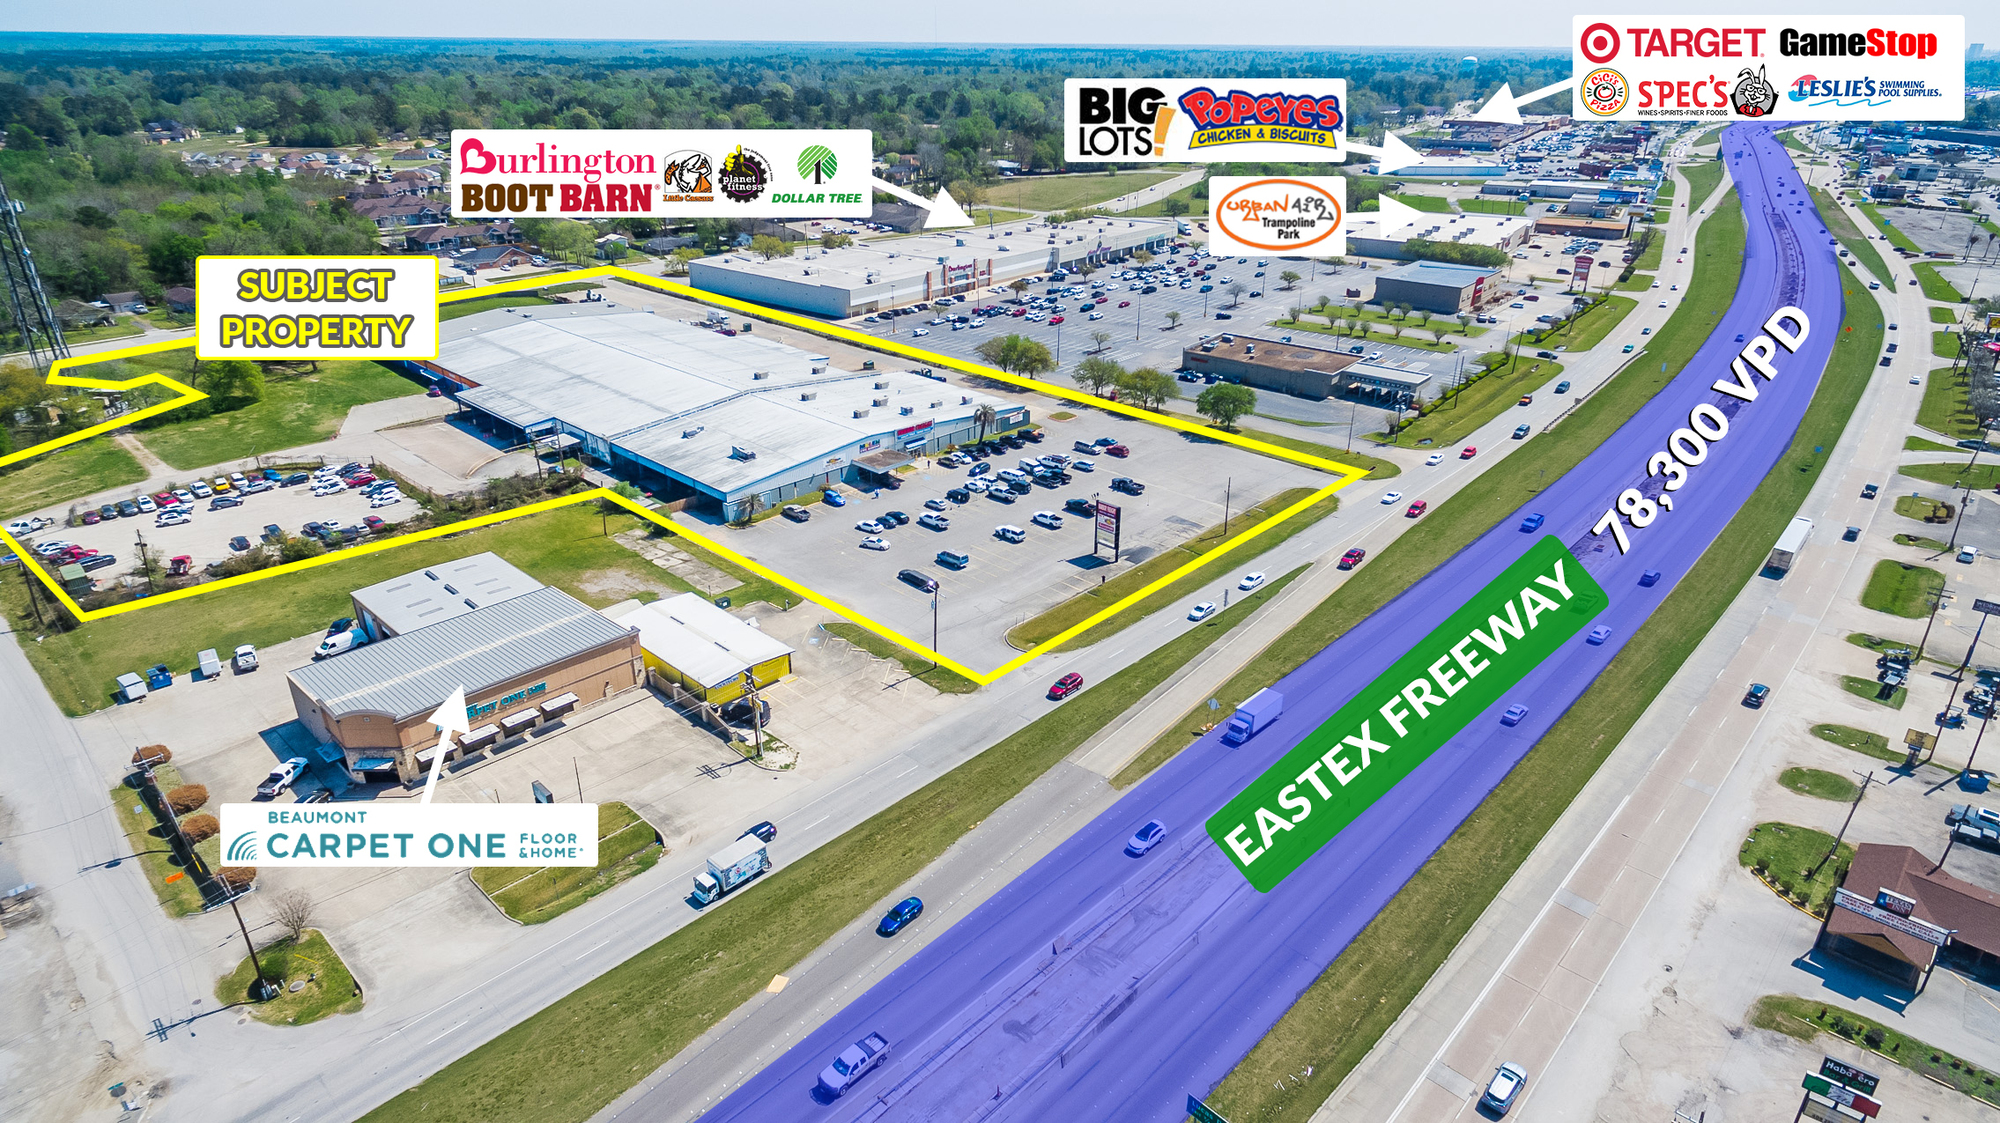

In [311]:
# We get back relevant images
plt_img_base64(docs[0])

In [327]:
chain_multimodal_rag.invoke(query)

'The first image shows an aerial map of a ±28,870 SF property for sale. The property is located near the Eastex Freeway with a traffic volume of 78,300 vehicles per day (VPD). It is surrounded by various retail stores and restaurants, including Burlington, Boot Barn, Dollar Tree, Big Lots, Popeyes, Urban Air Trampoline Park, Target, GameStop, Spec\'s, and Leslie\'s Pool Supplies. The property is highlighted and labeled as "SUBJECT PROPERTY" in the image.'

In [347]:
# Check retrieval
query = "Give the best SALE COMPS for ±28,870 SF Property for Sal "
docs = retriever_multi_vector_img.invoke(query, limit=6)

# We get 4 docs
len(docs)

4

In [351]:
chain_multimodal_rag.invoke(query)

'Based on the provided information, here are the best sale comparables (comps) for the ±28,870 SF property for sale:\n\n1. **Rose Plaza**\n   - **Location:** 4015 South Broadway Avenue, Tyler, TX 75701\n   - **Sale Price:** $10,190,000\n   - **Building SF:** 33,941 SF\n   - **Price PSF:** $300.23\n   - **Cap Rate:** 5.52%\n   - **Closed:** 11/20/2020\n\n2. **Imperial Oaks Plaza**\n   - **Location:** 2021 Rayford Road, Spring, TX 77386\n   - **Sale Price:** $2,235,000\n   - **Building SF:** 14,983 SF\n   - **Price PSF:** $149.17\n   - **Cap Rate:** 6.27%\n   - **Closed:** 12/23/2020\n\n3. **TimberHeights Center**\n   - **Location:** 2036 East T C Jester Boulevard, Houston, TX 77008\n   - **Sale Price:** $6,145,000\n   - **Building SF:** 17,865 SF\n   - **Price PSF:** $343.97\n   - **Cap Rate:** 6.45%\n   - **Closed:** 02/27/2020\n\n4. **Harbor Freight Center**\n   - **Location:** 4325 Highway 6, Sugar Land, TX 77478\n   - **Sale Price:** $3,315,000\n   - **Building SF:** 18,534 SF\n   -

In [353]:
# Check retrieval
query = "Provide me the GREELEY location overview image"
docs = retriever_multi_vector_img.invoke(query, limit=6)

# We get 4 docs
len(docs)

4


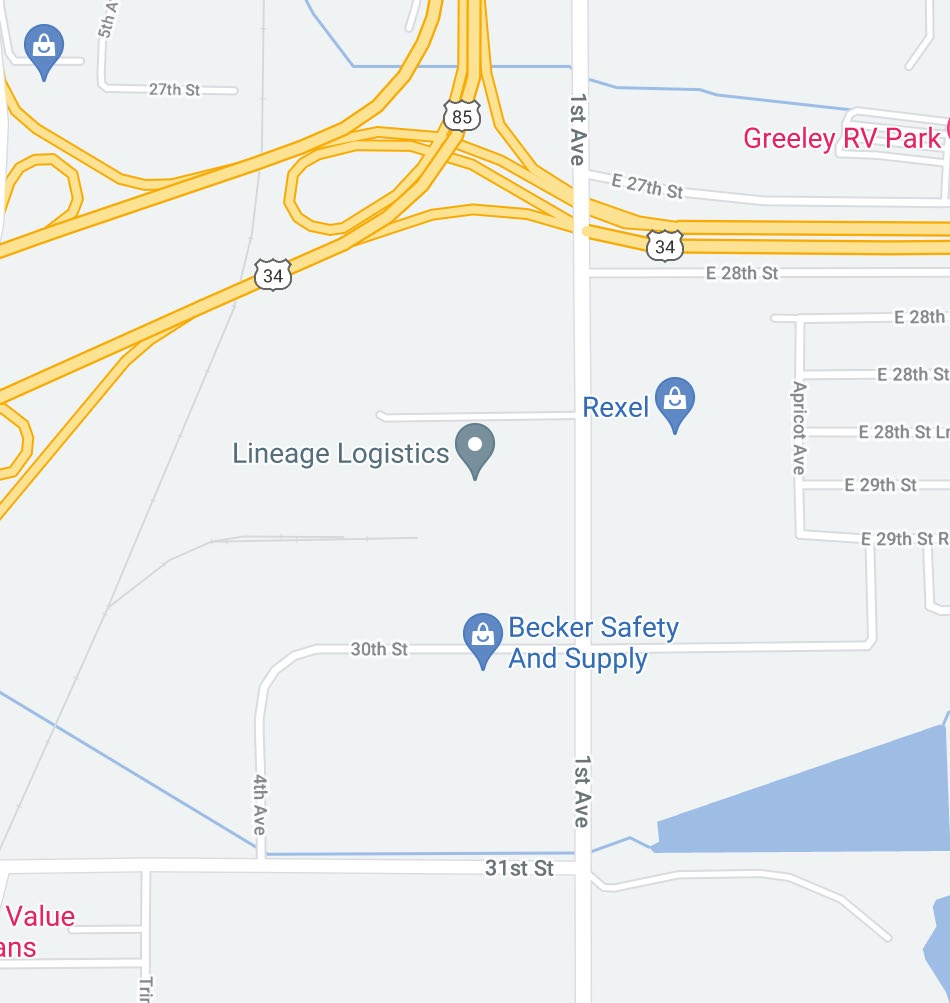

In [355]:
# We get back relevant images
plt_img_base64(docs[0])

### RAG

Now let's run RAG and test the ability to synthesize an answer to our question.

In [30]:
query = """Compare the below different properties.  
         1.±28,870 SF Property for Sale 300 East Main Street, Durham, North Carolina
         2.609-615 E 26th Street Garden City, CO 80631
         3.West Lake Main Street, Hawthorne, FL 32640

         In terms of cost, parking,grm, cap rate, price/unit, lot size and location.
         
         Suggest me the best property to purchase.
"""
# Run RAG chain
print(chain_multimodal_rag.invoke(query))

To compare the three properties based on the given criteria, here is a detailed analysis:

### Property 1: 300 East Main Street, Durham, North Carolina
- **Cost**: $11,900,000
- **Parking**: 2 Internal Garage Spaces + Street
- **GRM (Gross Rent Multiplier)**: Not provided
- **Cap Rate**: Not provided
- **Price/Unit**: Not provided
- **Lot Size**: 0.295 acres
- **Location**: Downtown Durham, NC

### Property 2: 609-615 E 26th Street, Garden City, CO 80631
- **Cost**: Not provided
- **Parking**: Not provided
- **GRM (Gross Rent Multiplier)**: Not provided
- **Cap Rate**: Not provided
- **Price/Unit**: Not provided
- **Lot Size**: Not provided
- **Location**: Garden City, CO

### Property 3: West Lake Main Street, Hawthorne, FL 32640
- **Cost**: Not provided
- **Parking**: Not provided
- **GRM (Gross Rent Multiplier)**: Not provided
- **Cap Rate**: Not provided
- **Price/Unit**: Not provided
- **Lot Size**: Not provided
- **Location**: Hawthorne, FL

### Comparison and Recommendation:
1. 

In [32]:
query="what is the price of 609-615 E 26th Street, Garden City, CO 8063?"
print(chain_multimodal_rag.invoke(query))

The price of the property located at 609-615 E 26th Street, Garden City, CO 80631 is $1,375,000.


In [34]:
query = "Give the SALE COMPS for 609-615 E 26th Street, Garden City, CO 8063 in tabular format and advice me which one to purchase in terms of cost"
# Run RAG chain
print(chain_multimodal_rag.invoke(query))

Here are the sale comps in tabular format:

| Purchase Price | Equity     | Mortgage  | Sale Price  | Commissions & Overhead | Total Acquisition, Improvements & Overhead | Net Proceeds |
|----------------|------------|-----------|-------------|------------------------|--------------------------------------------|--------------|
| $4,960,000     | $248,000   | -0-       | $6,045,000  | $483,600               | ($5,443,600)                               | $601,400     |
| $9,455,000     | $472,750   | -0-       | $11,285,000 | $902,800               | ($10,357,800)                              | $927,200     |
| $2,475,000     | $123,750   | -0-       | $3,150,000  | $252,000               | ($2,727,000)                               | $423,000     |
| $46,812,000    | $11,703,000| $35,109,000| $93,624,000 | $7,489,920             | ($54,301,920)                              | $39,319,080  |

**Advice on Purchase in Terms of Cost:**

Based on the net proceeds, the property with the highe